In [81]:
import glob
import os
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from matplotlib_venn import venn3
import seaborn as sns
import numpy as np
from venny4py.venny4py import *

# Finetuning

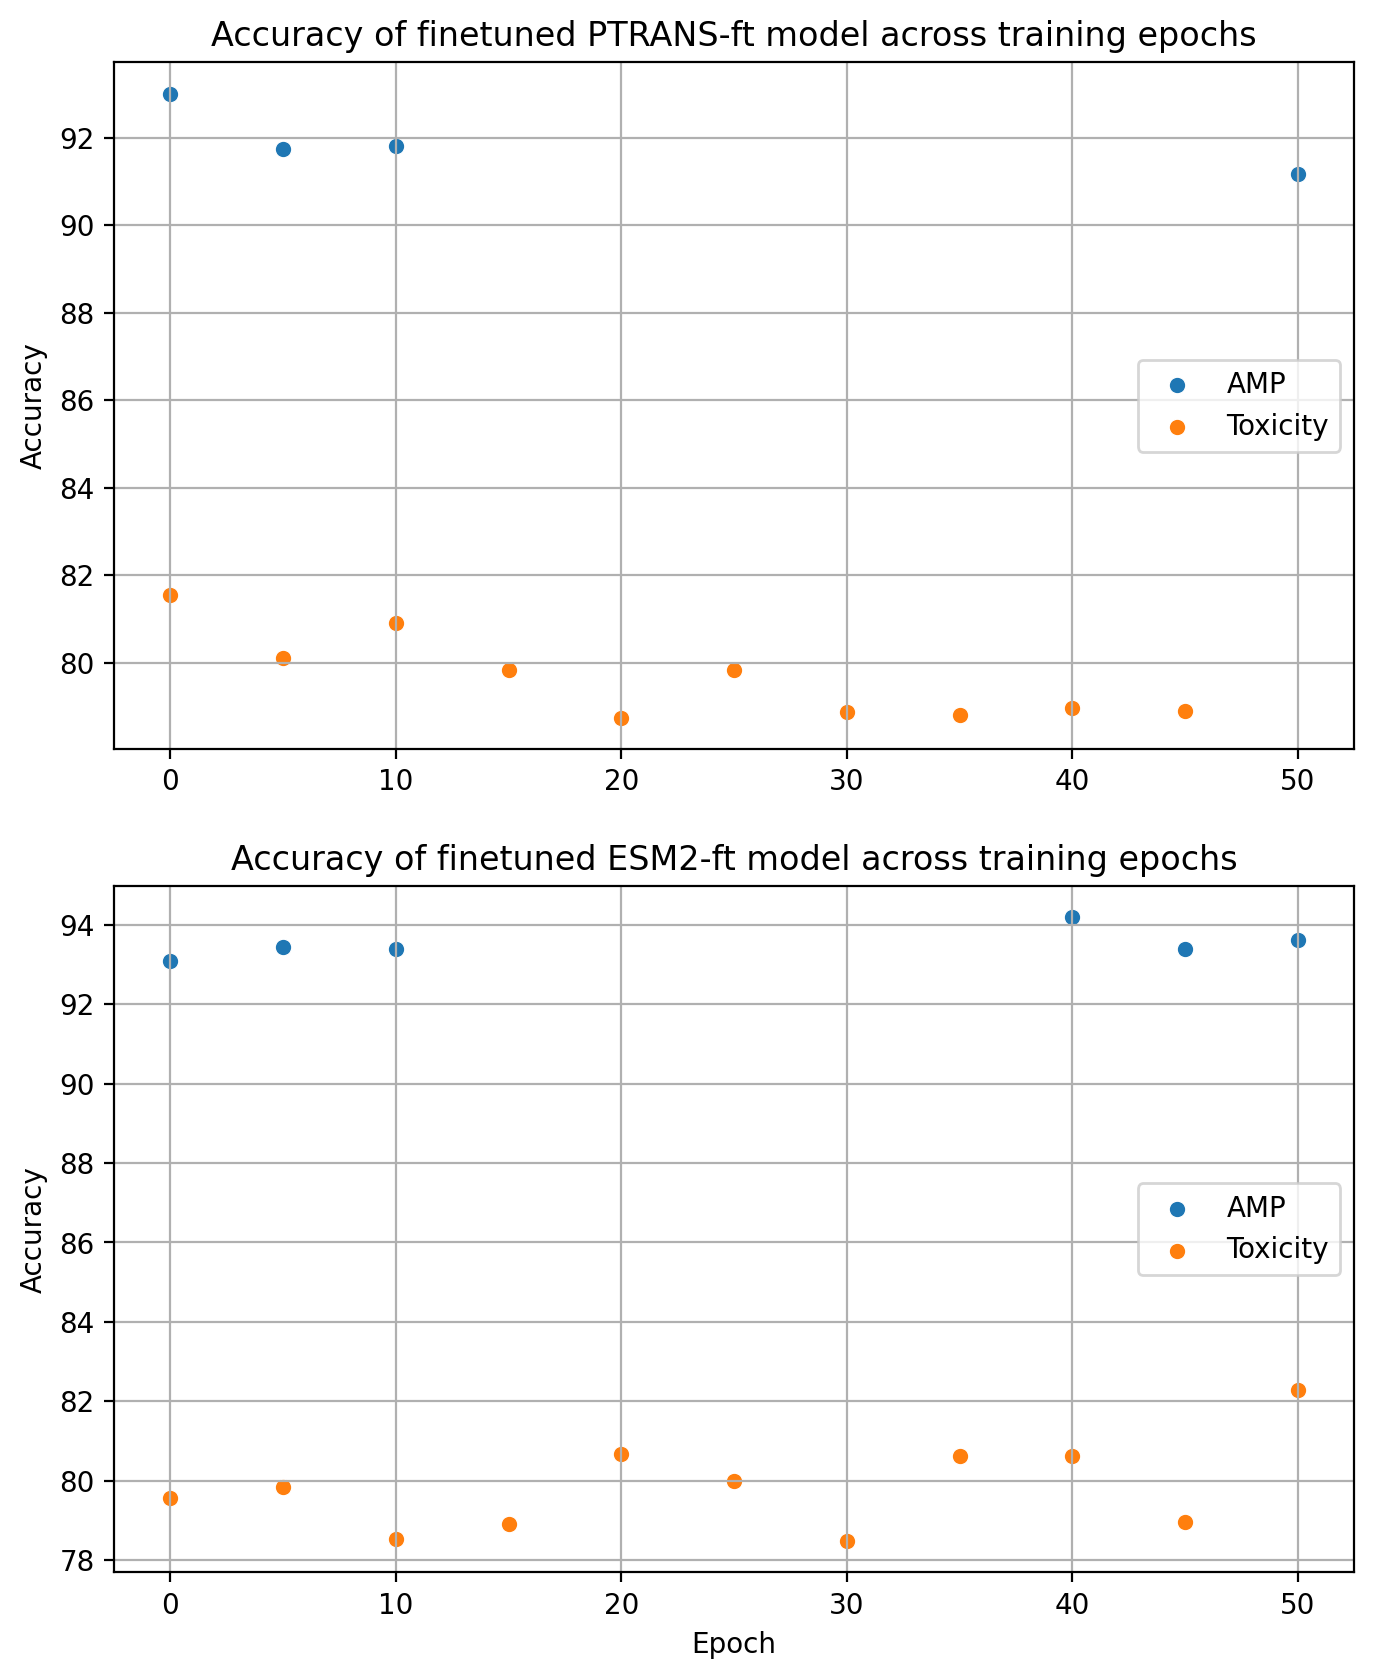

In [152]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8, 10))
for ind, (model, df_path) in enumerate(zip(['PTRANS-ft', 'ESM2-ft'], ['../data/predictions/ripp_lab_validation/AMP_PTRANS-ft.csv', 
                                                     '../data/predictions/ripp_lab_validation/AMP_ESM2-ft.csv'])):
    df_ft = pd.read_csv(df_path)
    sns.scatterplot(data=df_ft[df_ft['Metric'] == 'Accuracy'], x='Epoch', y='AMP', ax=axs[ind])
    sns.scatterplot(data=df_ft[df_ft['Metric'] == 'Accuracy'], x='Epoch', y='Tox', ax=axs[ind])
    axs[ind].legend(['AMP', 'Toxicity'], prop={'size': 10}, loc=5)
    axs[ind].set_ylabel('Accuracy')
    axs[ind].grid()
    axs[ind].set_title(f'Accuracy of finetuned {model} model across training epochs')
    if ind == 0:
        axs[ind].set_xlabel(None)
plt.savefig(f'finetuning_performance.png', dpi=200, bbox_inches='tight')

# Testing models

In [99]:
# amp_df = pd.read_excel('../data/predictions/ripp_lab_validation/AMP_test.xlsx', sheet_name='AMP')
amp_df = pd.read_csv('../data/predictions/ripp_lab_validation/AMP_test.csv')
amp_df.head()

,Base model,Score,Dataset,Metric
0,PTrans,93.01,AMP global,Accuracy
1,ESM-2 (650m),93.08,AMP global,Accuracy
2,ESM-2-ft,94.09,AMP global,Accuracy
3,ESM3,93.77,AMP global,Accuracy
4,PTrans,95.60,G+,Accuracy


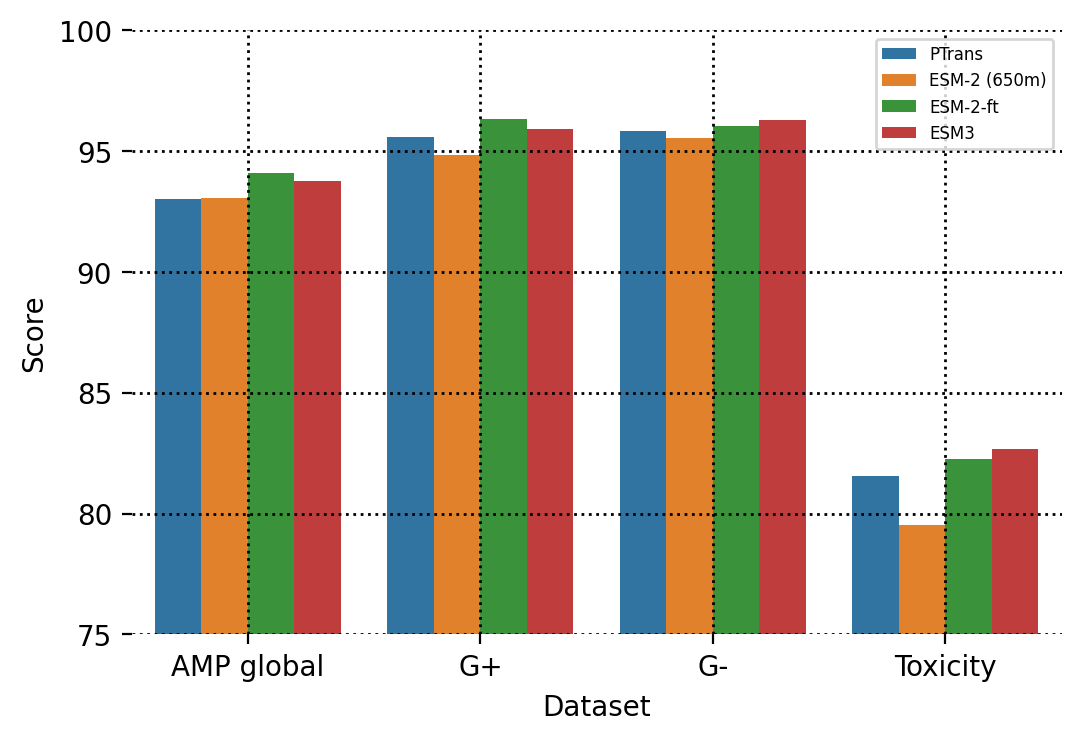

In [166]:
sns.barplot(data=amp_df[amp_df['Metric'] == 'Accuracy'], x='Dataset', y='Score', hue='Base model')
plt.ylim([75, 100])
plt.grid(zorder=0, linewidth=1, linestyle=':', color='k')
plt.legend(prop={'size': 6})
plt.box(False)
plt.savefig(f'testing_models.png', dpi=200, bbox_inches='tight')

In [123]:
for ds, ds_path in zip(['amp', 'G+', 'G-', 'tox'], 
                       ['../data/AMP_new/AMP_2024_08_09.tsv', '../data/AMP_new/AMP_2024_09_13_anti_Gram+.tsv',
                        '../data/AMP_new/AMP_2024_09_13_anti_Gram-.tsv', '../data/tox/tox_merged_all.tsv']):

    df = pd.read_csv(ds_path, sep='\t', header=None)
    cnt = Counter(df[3])
    print(f'{ds}, size={len(df)}, 0: {cnt[0]}', f'1: {cnt[1]}')


amp, size=55209, 0: 30205 1: 25004
G+, size=45069, 0: 30205 1: 14864
G-, size=45493, 0: 30205 1: 15288
tox, size=12961, 0: 6643 1: 6318


# Lab validation AMP Tox G+ G-

Total number of ripp peptides: 12720
ESM2 G-: {0: 8849, 1: 3871}
ESM3 amp: {1: 7054, 0: 5666}
PTRANS amp: {1: 6848, 0: 5872}
ESM2 tox: {1: 3353, 0: 9367}
ESM2-ft amp: {0: 7358, 1: 5362}
ESM3 G+: {1: 4198, 0: 8522}
ESM3 G-: {1: 3969, 0: 8751}
ESM2-ft tox: {1: 501, 0: 12219}
PTRANS G+: {0: 8282, 1: 4438}
PTRANS G-: {0: 8644, 1: 4076}
ESM2 amp: {1: 6308, 0: 6412}
PTRANS tox: {1: 1885, 0: 10835}
ESM2-ft G+: {0: 11896, 1: 824}
ESM2 G+: {0: 8820, 1: 3900}
ESM3 tox: {1: 2116, 0: 10604}
ESM2-ft G-: {0: 11101, 1: 1619}
amp active and non-toxic predicted by models: 1604
amp active and non-toxic predicted by models within top 50.0%: 306


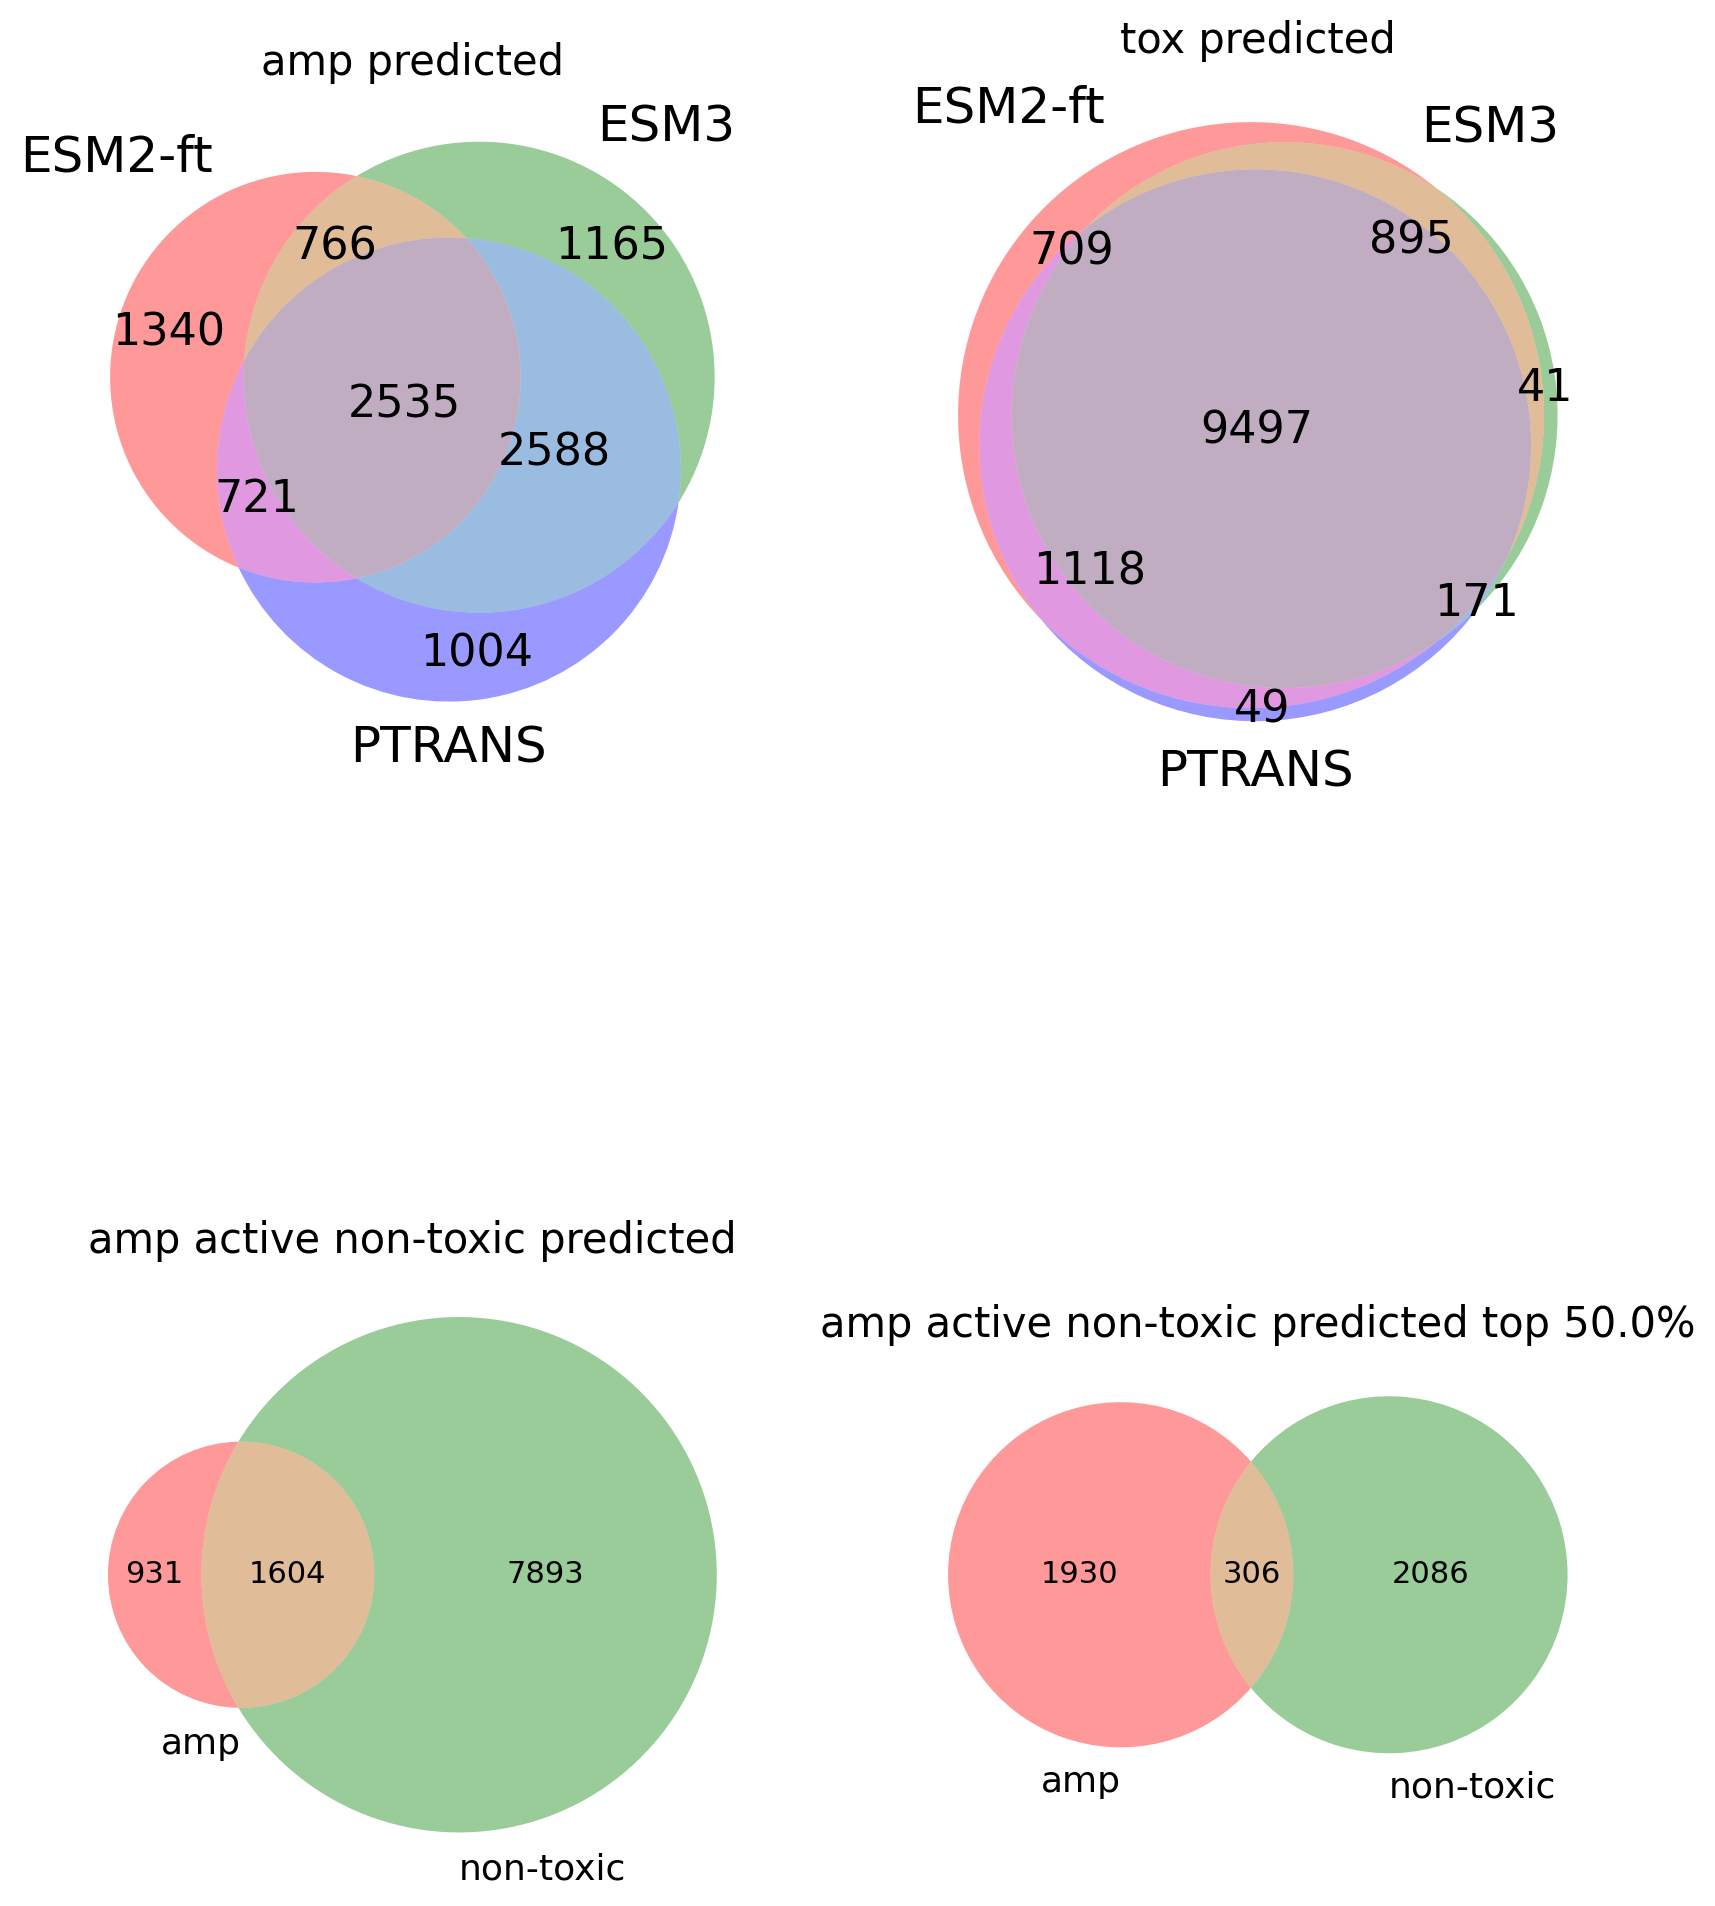

------------------------------------------------------------------------------------------
G+ active and non-toxic predicted by models: 138
G+ active and non-toxic predicted by models within top 50.0%: 5


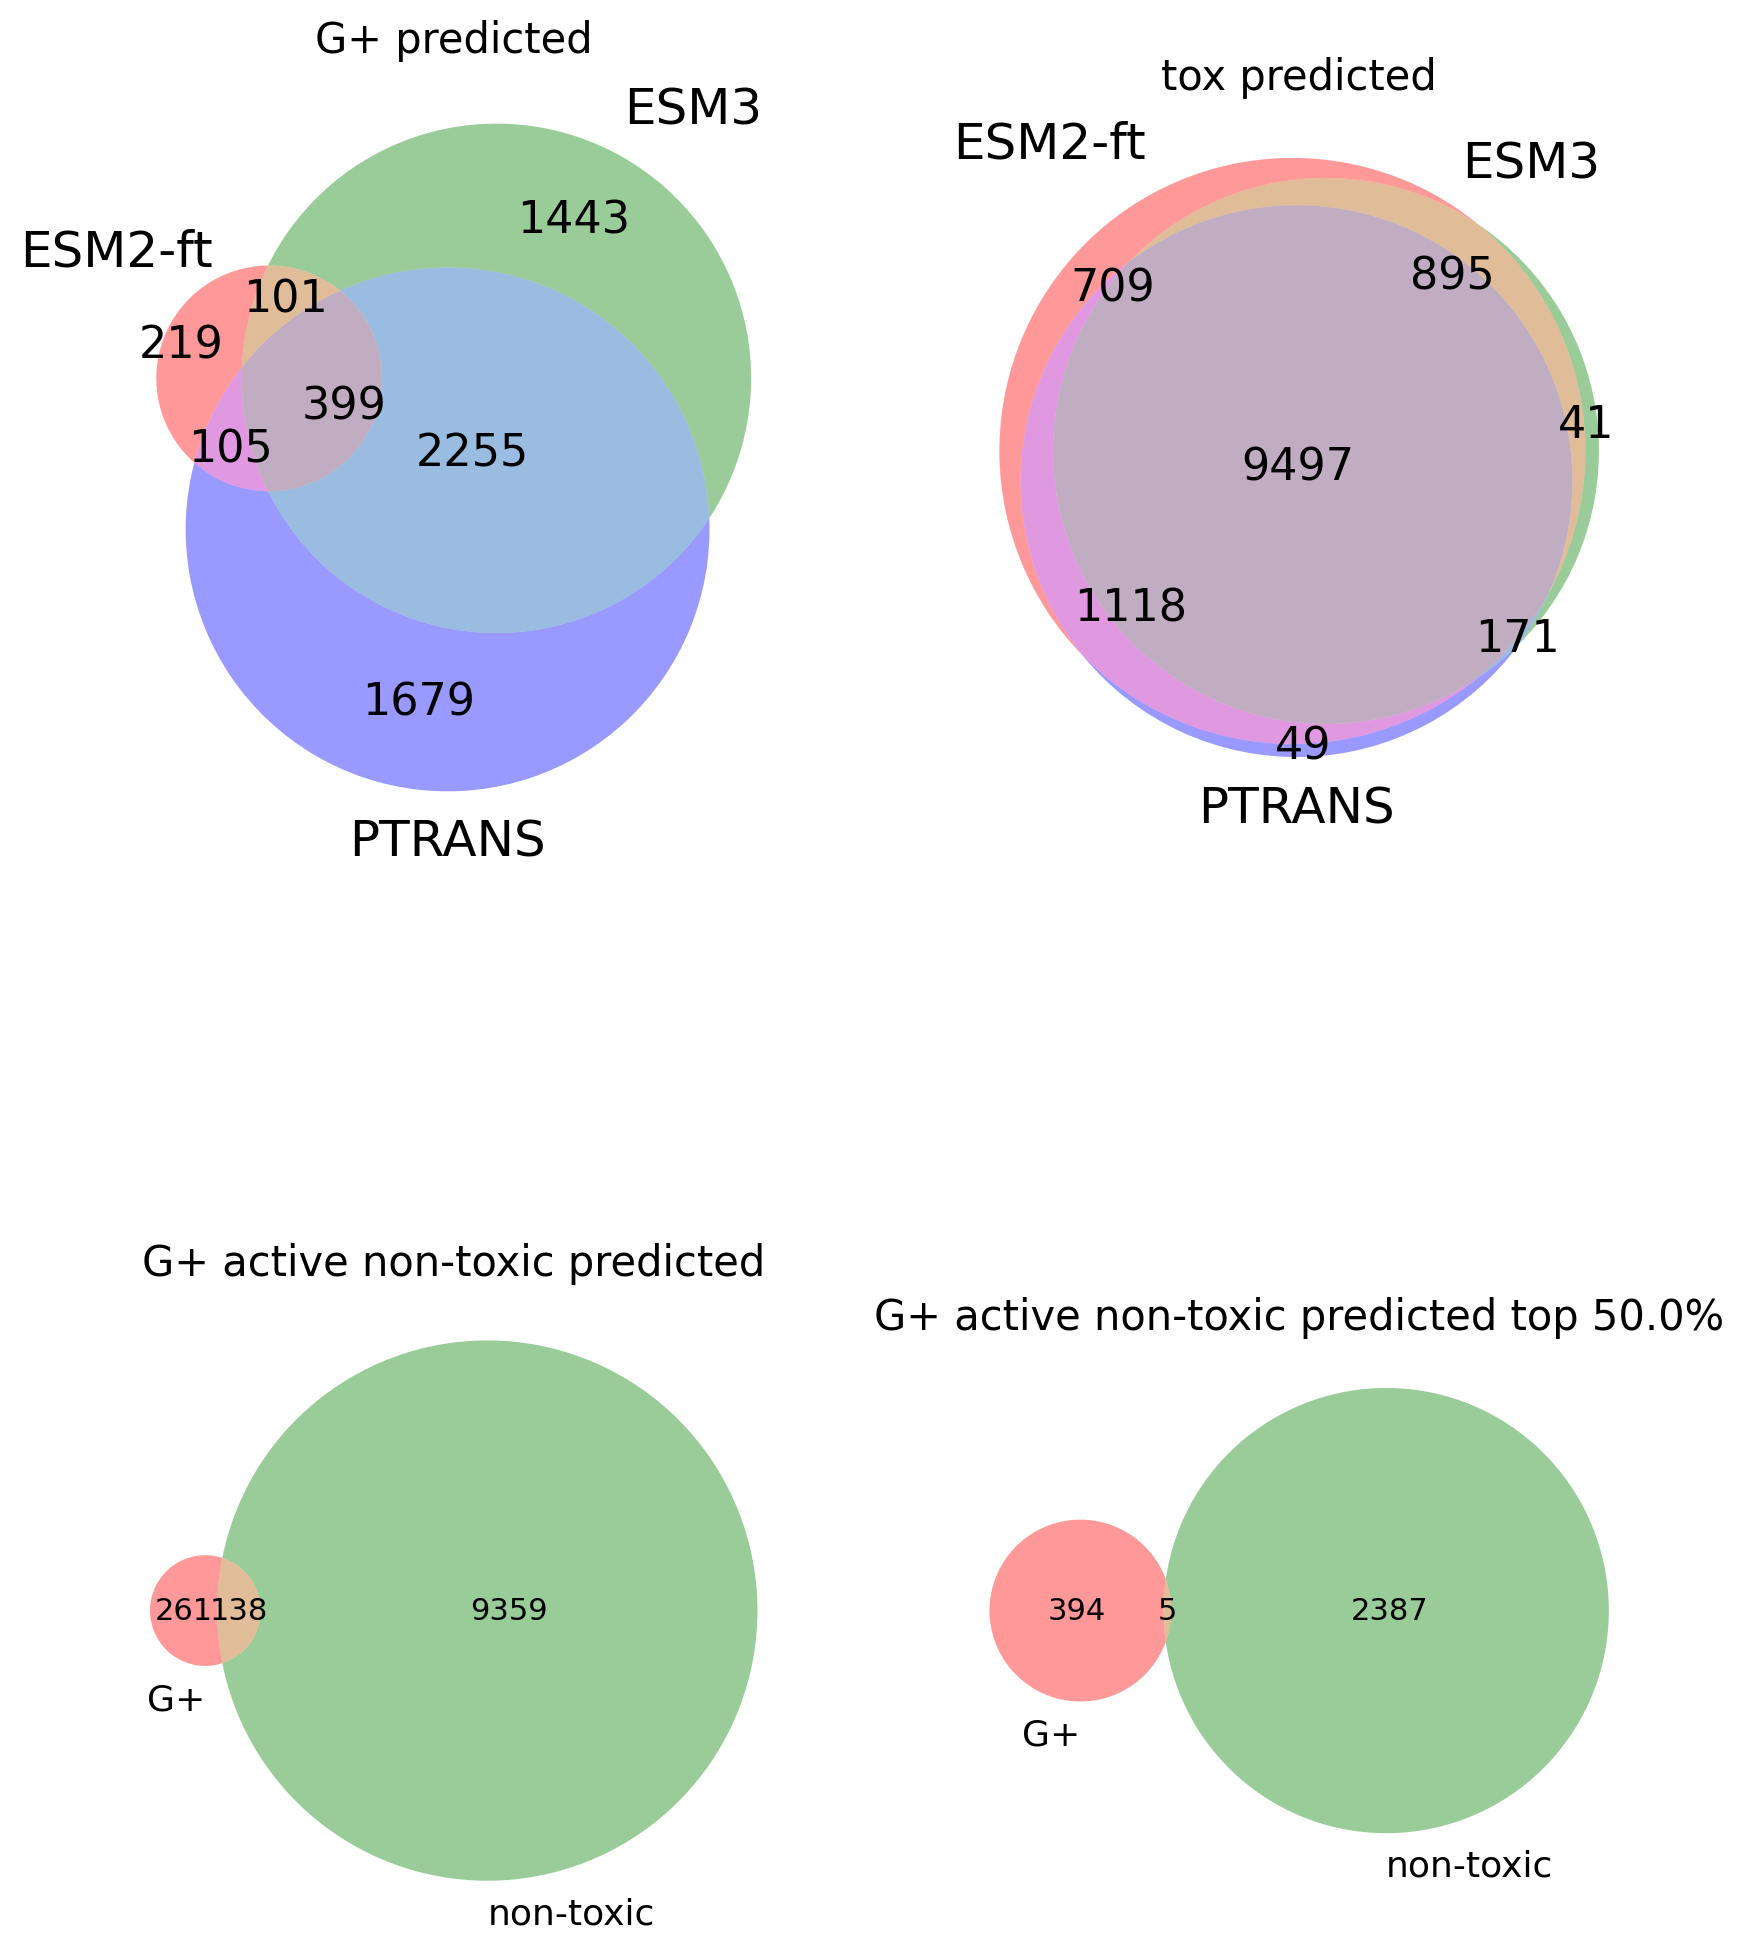

------------------------------------------------------------------------------------------
G- active and non-toxic predicted by models: 223
G- active and non-toxic predicted by models within top 50.0%: 13


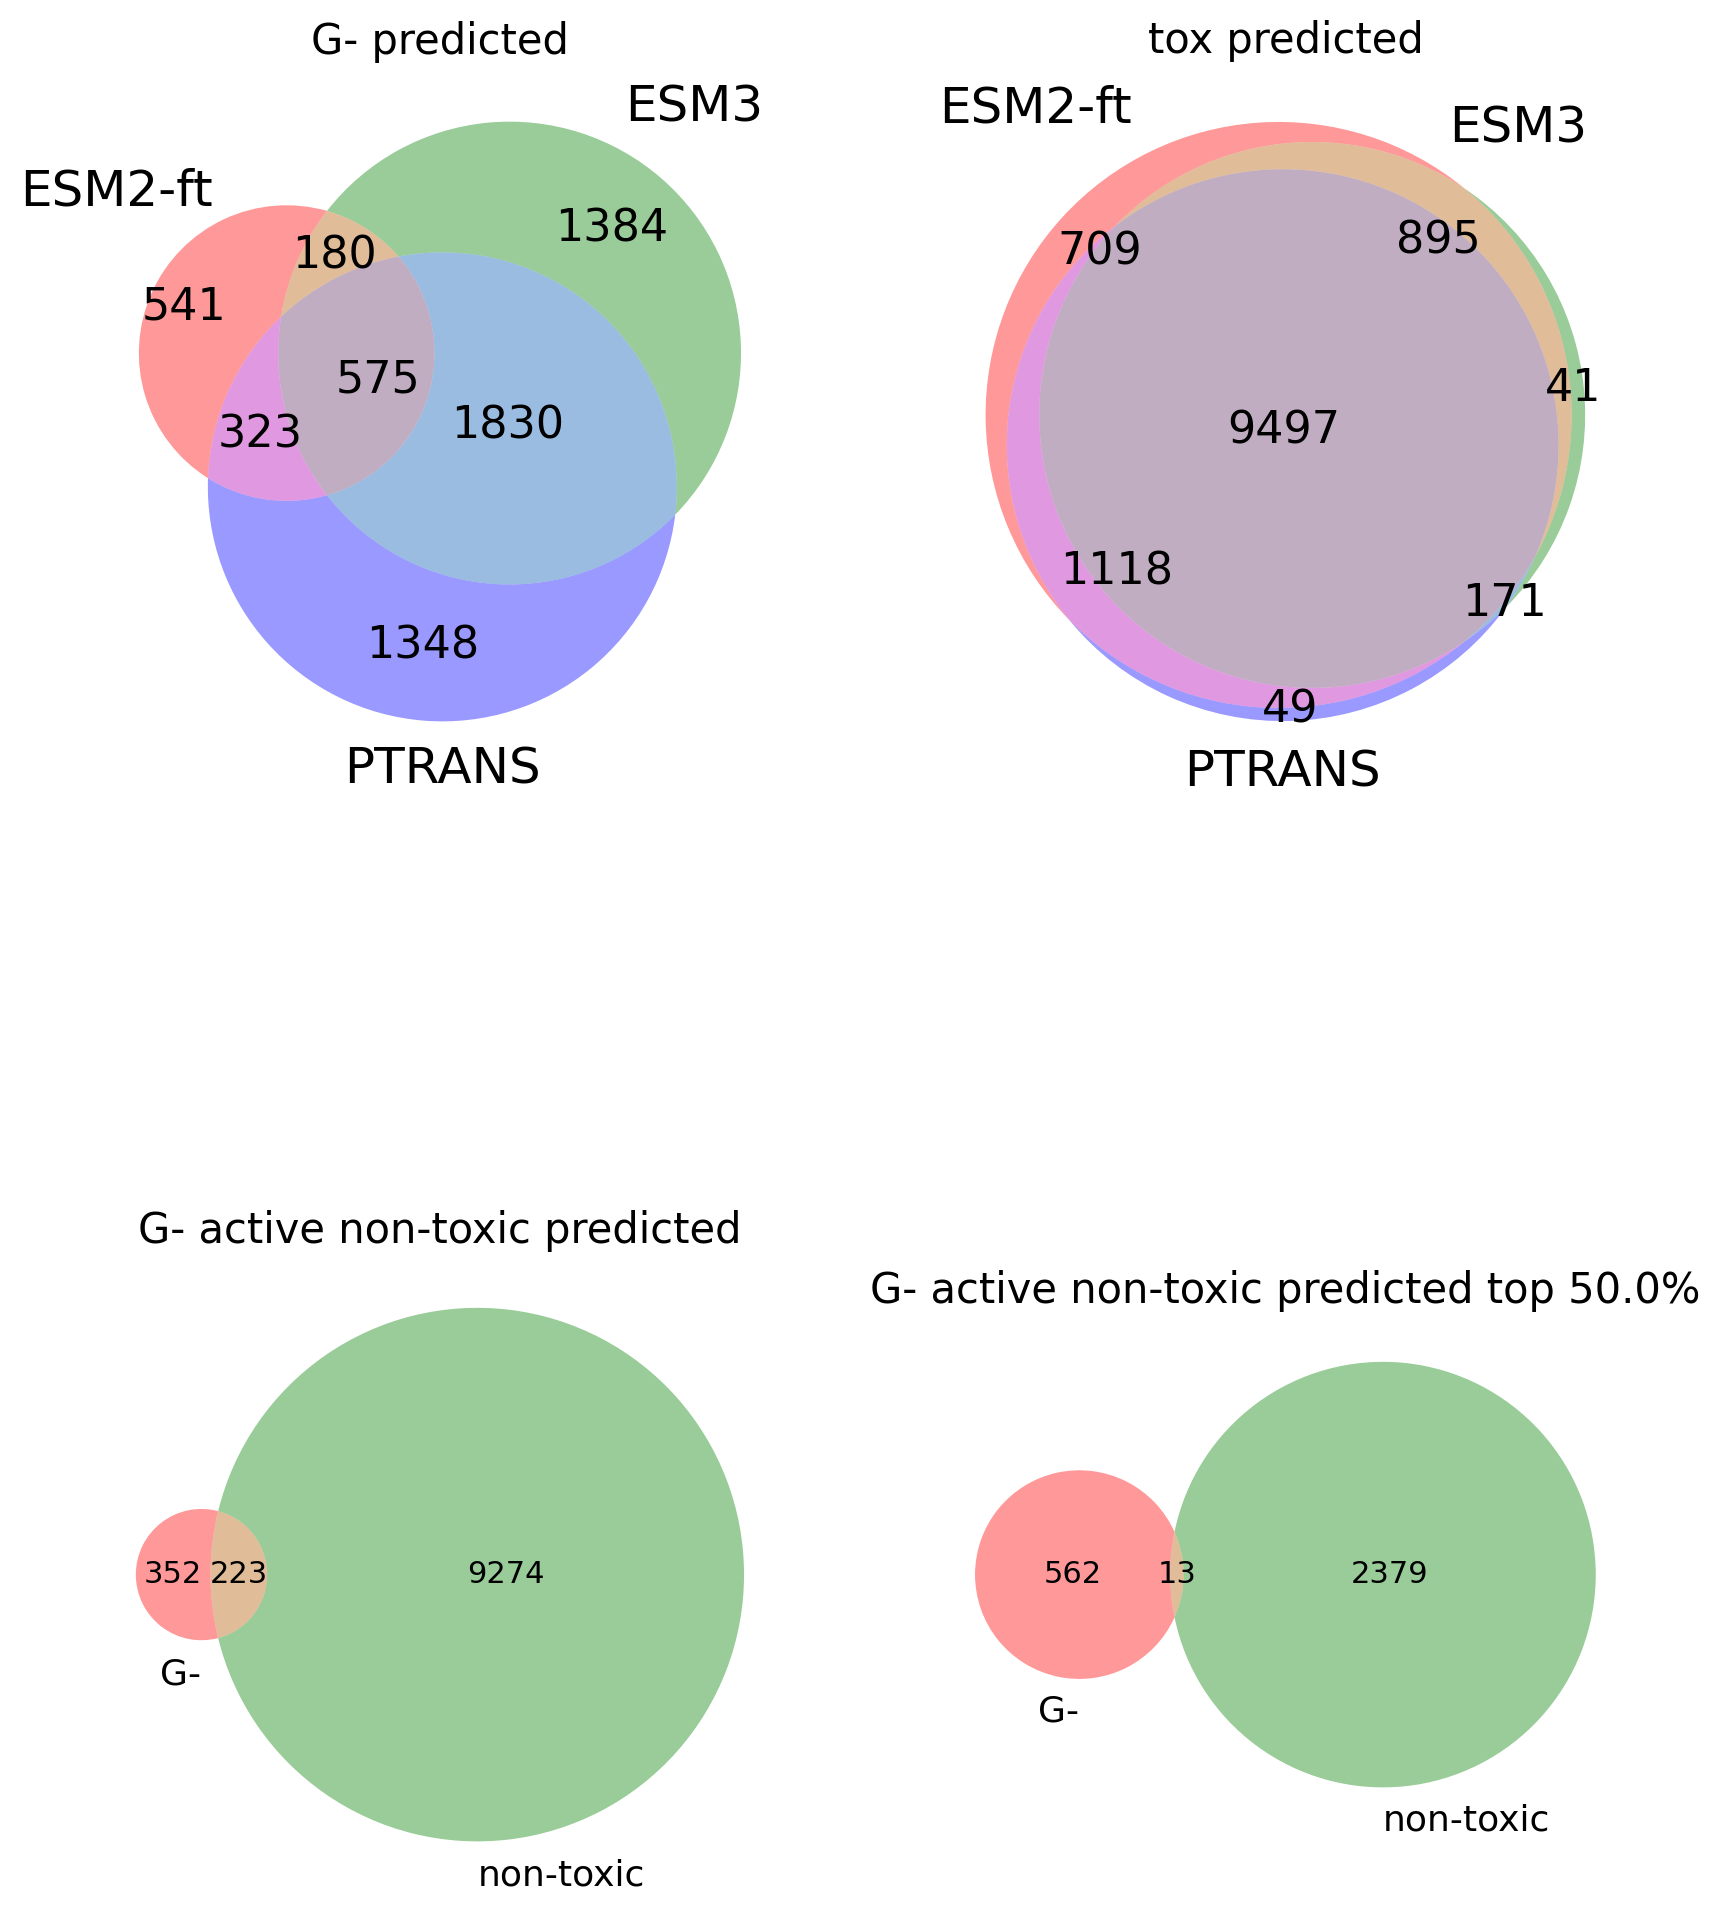

------------------------------------------------------------------------------------------


In [234]:
# Get data file names
path = '../data/predictions/ripp_lab_validation/'
filenames = glob.glob(path + "*.tsv")
top_percs = {'amp': 0.5, 'G+': 0.5, 'G-':0.5, 'tox': 0.50}
intersect_4 = False  # If true uses all 4 models, if false use ESM3, ESM2-ft and PTRANS

dfs_raw = {'amp': dict(), 'G+':dict(), 'G-':dict(), 'tox': dict()}
dfs = {'amp': dict(), 'G+':dict(), 'G-':dict(), 'tox': dict()}
sets = {'amp': dict(), 'G+':dict(), 'G-':dict(), 'tox': dict()}
dfs_top_perc = {'amp': dict(), 'G+':dict(), 'G-':dict(), 'tox': dict()}
sets_top_perc = {'amp': dict(), 'G+':dict(), 'G-':dict(), 'tox': dict()}
orig_df = pd.read_csv('../data/ripp_corepep.tsv', sep='\t', header=None)
print(f'Total number of ripp peptides: {len(orig_df)}')

for filename in filenames:
    model = os.path.basename(filename).split('_')[0]
    ds = os.path.basename(filename).split('_')[1]
    df = pd.read_csv(filename, sep='\t')
    size_top_perc = int(len(df) * top_percs[ds])
    dfs_raw[ds][model] = df.copy()
    if ds == 'tox':
        df = df[df['prediction'] == 0]  # Keep only non-toxic
    else:
        df = df[df['prediction'] == 1]  # Keep only AMP active
    df = df.sort_values(by='probability', ascending=False)
    # Normalize prediction score:
    df['probability_norm'] = (df['probability'] - df['probability'].min()) / (df['probability'].max() - df['probability'].min())
    df['probability_norm'] = df['probability_norm'].apply(lambda x: np.round(x, 4))
    if np.max(df['probability_norm'] ) > 1:
        display(df)
        break
    
    dfs[ds][model] = df.copy()
    sets[ds][model] = set(df['protein_id'].values)
    
    
    df = df.iloc[:size_top_perc, :]
    
    dfs_top_perc[ds][model] = df
    sets_top_perc[ds][model] = set(df['protein_id'].values)
    
    cnt = Counter(dfs_raw[ds][model]['prediction'])
    print(f'{model} {ds}: {dict(cnt)}')
    
for amp_ds in ['amp', 'G+', 'G-']:
    if intersect_4:
        amp_active = set.intersection(*list(sets[amp_ds].values()))
        non_toxic = set.intersection(*list(sets['tox'].values()))
        amp_active_top = set.intersection(*list(sets_top_perc[amp_ds].values()))
        non_toxic_top = set.intersection(*list(sets_top_perc['tox'].values()))
    else:
        amp_active = set.intersection(*[sets[amp_ds]['ESM2-ft'], sets[amp_ds]['ESM3'], sets[amp_ds]['PTRANS']])
        non_toxic = set.intersection(*[sets['tox']['ESM2-ft'], sets['tox']['ESM3'], sets['tox']['PTRANS']])
        amp_active_top = set.intersection(*[sets_top_perc[amp_ds]['ESM2-ft'], sets_top_perc[amp_ds]['ESM3'], sets_top_perc[amp_ds]['PTRANS']])
        non_toxic_top = set.intersection(*[sets_top_perc['tox']['ESM2-ft'], sets_top_perc['tox']['ESM3'], sets_top_perc['tox']['PTRANS']])

    
    for_lab = amp_active.intersection(non_toxic)
    for_lab_top_perc = amp_active_top.intersection(non_toxic_top)
    
    print(f'{amp_ds} active and non-toxic predicted by models: {len(for_lab)}')
    print(f'{amp_ds} active and non-toxic predicted by models within top {top_percs[amp_ds] * 100}%: {len(for_lab_top_perc)}')
    
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 14))
    for ind_st, st in enumerate([sets]):     # sets_top_perc
        for ind, ds in enumerate([amp_ds, 'tox']):
#             venn = venn2([st[ds]['ESM2'], st[ds]['ESM3']], set_labels=tuple('ESM2', 'ESM3'), ax=axs[ind_st][ind])
            if intersect_4:
                venn = venny4py(sets=st[ds], asax=axs[ind_st][ind])
            else:
                venn = venn3([st[ds]['ESM2-ft'], st[ds]['ESM3'], st[ds]['PTRANS']], set_labels=('ESM2-ft', 'ESM3', 'PTRANS'), ax=axs[ind_st][ind])
                for text in venn.set_labels:
                    text.set_fontsize(18)
                for text in venn.subset_labels:
                    text.set_fontsize(16)
            axs[ind_st][ind].set_title(f"{ds} predicted" + ((f' top {top_percs[ds]*100}%') if ind_st > 0 else ''), size=15)

    for ind, (act, tox) in enumerate(zip([amp_active, amp_active_top], [non_toxic, non_toxic_top])): 
        venn = venn2([act, tox], set_labels=tuple([amp_ds, 'non-toxic']), ax=axs[1][ind])
        for text in venn.set_labels:
            text.set_fontsize(13)
        for text in venn.subset_labels:
            if text:
                text.set_fontsize(11)
        axs[1][ind].set_title(f"{amp_ds} active non-toxic predicted" + ((f' top {top_percs[amp_ds]*100}%') if ind > 0 else ''), size=15)

    plt.savefig(f'{amp_ds}_tox_ripp_venn.png', dpi=200, bbox_inches='tight')
    plt.show()
  
    for_lab_all_df = orig_df[ orig_df[0].isin(for_lab)]
    for_lab_all_df = for_lab_all_df.loc[:, for_lab_all_df.columns != 3]
    for_lab_all_df.columns = ['protein id', 'length', 'sequence']
    for_lab_all_df.drop_duplicates(subset='sequence', inplace=True)
    score_columns = []
    for lab_ds in [amp_ds, 'tox']:
        for model in ['ESM2-ft', 'ESM3', 'PTRANS']:

            for_lab_all_df = pd.merge(left=for_lab_all_df, right=dfs[lab_ds][model][['protein_id', 'probability_norm']], 
                                      left_on='protein id', right_on='protein_id', how='left')
            for_lab_all_df.drop(columns='protein_id', inplace=True)
            for_lab_all_df.rename(columns={'probability_norm': lab_ds + '_' + model + '_norm_score'}, inplace=True)
            score_columns.append(lab_ds + '_' + model + '_norm_score')
    for_lab_all_df.loc[:, 'avg_score'] = for_lab_all_df[score_columns].mean(axis=1).apply(lambda x: np.round(x, 4))
    for_lab_all_df.loc[:, f'is_in_top_{int(top_percs[amp_ds]*100)}'] = for_lab_all_df['protein id'].isin(for_lab_top_perc)

    for_lab_all_df.sort_values(by='avg_score', inplace=True, ascending=False)
    for_lab_all_df.to_csv(f'lab_validation_{amp_ds}.csv', index=False)
    print('-' * 90)


# AMP Toxicity RIPP - obsolete

In [61]:
# Get data file names
path = '../data/predictions/amp_ripp/'
filenames = glob.glob(path + "*.tsv")

dfs_raw = {'esm2': dict(), 'esm3': dict()}
dfs = {'esm2': dict(), 'esm3': dict()}
sets = {'esm2': dict(), 'esm3': dict()}

top_perc = 0.20

dfs_top_perc = {'esm2': dict(), 'esm3': dict()}
sets_top_perc = {'esm2': dict(), 'esm3': dict()}
for filename in filenames:
    model = os.path.basename(filename).split('_')[0]
    ds = os.path.basename(filename).split('_')[1]
    df = pd.read_csv(filename, sep='\t')
    size_top_perc = int(len(df) * top_perc)
    dfs_raw[model][ds] = df.copy()
    if ds == 'tox':
        df = df[df['prediction'] == 0]  # Keep only non-toxic
    else:
        df = df[df['prediction'] == 1]  # Keep only AMP active
    dfs[model][ds] = df
    sets[model][ds] = set(df['protein_id'].values)
    
    df = df.sort_values(by='probability', ascending=False)
    df = df.iloc[:size_top_perc, :]
    
    dfs_top_perc[model][ds] = df
    sets_top_perc[model][ds] = set(df['protein_id'].values)
    
    cnt = Counter(dfs_raw[model][ds]['prediction'])
    print(f'{model} {ds}: {dict(cnt)}')
    
for_lab = set(dfs_raw['esm2']['tox']['protein_id'].values)  # Get all protein IDs
for_lab_top_perc = for_lab.copy()
for ds in ['tox', 'amp']:
    for_lab = for_lab.intersection(sets['esm2'][ds].intersection(sets['esm3'][ds]))
    for_lab_top_perc = for_lab_top_perc.intersection(sets_top_perc['esm2'][ds].intersection(sets_top_perc['esm3'][ds]))
        
print(f'Top {int(top_perc * 100)}% ({len(sets_top_perc[model][ds])} peptides) in {model} {ds}')
print(f'AMP active and non-toxic predicted by ESM2 and ESM3: {len(for_lab)}')
print(f'AMP active and non-toxic predicted by ESM2 and ESM3 within top {top_perc * 100}% ({len(sets_1top_perc[model][ds])} peptides from each): {len(for_lab_top_perc)}')

esm2 tox: {0: 9908, 1: 2812}
esm3 tox: {0: 9740, 1: 2980}
esm3 amp: {1: 6813, 0: 5907}
esm2 amp: {1: 6260, 0: 6460}
Top 20% (2544 peptides) in esm2 amp
AMP active and non-toxic predicted by ESM2 and ESM3: 3095
AMP active and non-toxic predicted by ESM2 and ESM3 within top 20.0% (1272 peptides from each): 38


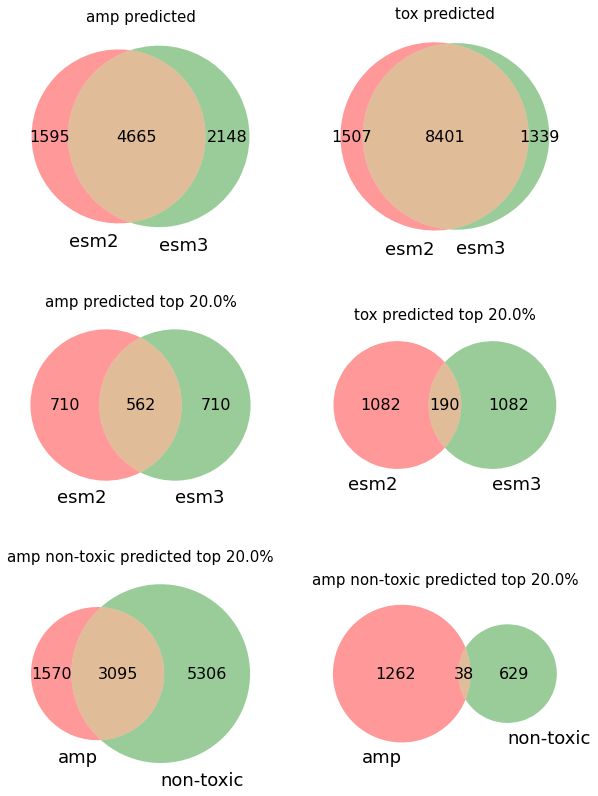

In [62]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 14))
for ind_st, st in enumerate([sets, sets_1top_perc]):     
    for ind, ds in enumerate(['amp', 'tox']):
        venn = venn2([st['esm2'][ds], st['esm3'][ds]], set_labels=tuple(st.keys()), ax=axs[ind_st][ind])
        for text in venn.set_labels:
            text.set_fontsize(18)
        for text in venn.subset_labels:
            text.set_fontsize(16)
        axs[ind_st][ind].set_title(f"{ds} predicted" + (f' top {top_perc*100}%' if ind_st > 0 else ''), size=15)
   

for ind, st in enumerate([sets, sets_top_perc]): 
    venn = venn2([st['esm2']['amp'].intersection(st['esm3']['amp']), 
                  st['esm2']['tox'].intersection(st['esm3']['tox'])], set_labels=tuple(['amp', 'non-toxic']), ax=axs[2][ind])
    for text in venn.set_labels:
        text.set_fontsize(18)
    for text in venn.subset_labels:
        text.set_fontsize(16)
    axs[2][ind].set_title(f"amp non-toxic predicted" + (f' top {top_perc*100}%' if ind_st > 0 else ''), size=15)

plt.savefig('amp_tox_ripp_venn.png', dpi=150, bbox_inches='tight')
plt.show()

In [66]:
orig_df = pd.read_csv('../data/ripp_corepep.tsv', sep='\t', header=None)
for_lab_df = orig_df[ orig_df[0].isin(for_lab_top_perc)]  # Labels (column 3) given here are random! Ignore them!
for_lab_df.to_csv('amp_non_toxic.tsv', sep='\t', index=False, header=False)
for_lab_df

,0,1,2,3
5882,SRR23617280.bin.29_k141_328097.region001-gene2,11,SSAVASSAVTV,1
5975,SRR23823798.bin.10_k141_178736.region001-gene20,31,GVVENGVFTKVDKVLVGNPKKVKTLKNKNKK,0
6050,SRR23823802.bin.23_k141_58835.region001-gene16,31,GVVENGVFTKVDKVLVGNPKKVKTLKNKNKK,1
6083,SRR23823804.bin.7_k141_13186.region001-gene5,31,GVVENGVFTKVDKVLVGNPKKVKTLKNKNKK,0
6219,SRR23823813.bin.7_k141_39352.region001-gene5,31,GVVENGVFTKVDKVLVGNPKKVKTLKNKNKK,1
6230,SRR23823814.bin.25_k141_83051.region001-gene18,31,GVVENGVFTKVDKVLVGNPKKVKTLKNKNKK,1
6433,SRR23823830.bin.42_k141_99872.region001-gene17,31,GVVENGVFTKVDKVLVGNPKKVKTLKNKNKK,0
6457,SRR23823832.bin.11_k141_27281.region001-gene20,31,GVVENGVFTKVDKVLVGNPKKVKTLKNKNKK,1
6472,SRR23823834.bin.20_k141_26932.region001-gene9,22,SGVSSAVAGVIIDSIPGPAIPG,1
6541,SRR23823841.bin.19_k141_72094.region001-gene5,31,GVVENGVFTKVDKVLVGNPKKVKTLKNKNKK,0
